# **Experiment 4: Random Forest**

__Steps:__

1. Load datasets and create functions
2. Data splitting
3. Cross-validation with default hyperparameters
4. Reduce Overfitting with n_estimators
5. Reduce Overfitting with max_depth
6. Reduce Overfitting with min_samples_leaf
7. Reduce Overfitting with max_features
8. Auto tuning using Random Search
9. Assess the best RandomForest Model on testing set
10.  Features Importance


## **1. Load datasets and create functions** 

**[1.1]** Import packages

In [1]:
import pandas as pd
import math 
import numpy as np
from itertools import repeat

# train test split
from sklearn.model_selection import train_test_split
# performance metrics
from sklearn.metrics import recall_score, precision_score, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# visualization 
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.disable_max_rows()

# cross validate 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from scipy.stats import randint

# classfier
from sklearn.ensemble import RandomForestClassifier

**[1.2]** Load the training dataset into dataframe called df_data

In [2]:
df_data = pd.read_csv('./repurchase_data-prepared.csv')

**[1.3]** Load the training dataset into dataframe called df_test

In [3]:
df_test = pd.read_csv('./repurchase_test-prepared.csv')

**[1.4]** Create a function to summarize cross-validation results of tested hyperparameter values

In [4]:
def summarize_cv_hyperparameter(cv_scores, hyperparam_name, hyperparam_values):
    """
    Parameters:
        cv_scores (nd array): average cross-validation scores of tested hyperparameter values. 
        hyperparam_name: name of the hyperparameter (e.g. n_estimators)
        hyperparam_value (1d array): different values of the hyperparameter (e.g. [10, 50, 100])
    Return:
        A Dataframe that contains 4 columns:
        - hyperparam_name: the hyperparameter value
        - recall_score: average cross-validation recall of a given hyperparameter value on a given set.
        - dataset: the type of dataset on which recall_score is calculated. Either train or test.
        - overfitting: the difference between train_score and test_score 
    """
    recall_scores = []
    n_hyperparam_values = len(hyperparam_values)
    dataset = ['train', 'test'] * n_hyperparam_values
    overfitting = []
    
    # loop through average cross-validation scores of each hyperparameter value
    for item in cv_scores:
        recall_scores.append(item['train_score'])
        recall_scores.append(item['test_score'])
        overfitting.extend(repeat(item['train_score'] - item['test_score'],2))
    return pd.DataFrame({hyperparam_name: sorted(hyperparam_values * 2), 'recall_score': recall_scores, 'dataset': dataset, 'overfitting': overfitting})

**[1.5]** Let's call summarize_cv_hyperparameter() to see its sample output

In [5]:
cv_scores = [{'fit_time': 1.5408970355987548,
  'score_time': 0.08309478759765625,
  'test_score': 0.8059482508849502,
  'train_score': 0.885828966681908},
 {'fit_time': 2.798608589172363,
  'score_time': 0.14132475852966309,
  'test_score': 0.8261752012395601,
  'train_score': 0.8979588292214935},
 {'fit_time': 5.526672983169556,
  'score_time': 0.2539525985717773,
  'test_score': 0.848875703866068,
  'train_score': 0.9004675343651036},
 {'fit_time': 11.310441589355468,
  'score_time': 0.9044121074676513,
  'test_score': 0.9041454089666554,
  'train_score': 0.9994675343651036}]
sample_summary = summarize_cv_hyperparameter(cv_scores, 'n_estimators', [25, 50, 100, 200])
sample_summary

,n_estimators,recall_score,dataset,overfitting
0,25,0.885829,train,0.079881
1,25,0.805948,test,0.079881
2,50,0.897959,train,0.071784
3,50,0.826175,test,0.071784
4,100,0.900468,train,0.051592
5,100,0.848876,test,0.051592
6,200,0.999468,train,0.095322
7,200,0.904145,test,0.095322


**[1.6]** Create a function to plot train scores vs test scores of different hyperparameter values to see bias-variance trade-off

In [6]:
def compare_train_test(summary, hyperparam_name):
    return alt.Chart(summary).mark_line(point=True).encode(
        x=hyperparam_name,
        y='recall_score',
        color='dataset',
    )

**[1.7]** Let's call compare_train_test() to see its sample output

In [7]:
compare_train_test(sample_summary, 'n_estimators')

alt.Chart(...)

## 2. Data Splitting

**[2.1]** Extract target values and independent values from df_data

In [8]:
y_data = df_data.pop('Target')
X_data = df_data

**[2.2]** Extract target values and independent values from df_test

In [9]:
y_test = df_test.pop('Target')
X_test = df_test

**[2.3]** Instantiate a StratifiedKFold with 3 splits

In [10]:
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 8)
cv = list(skf.split(X_data, y_data))

## 3. Cross validation with Default Hyperparameters

**[3.1]** Fit the RandomForest model with default hyperparameters n_estimators = 100, max_depth = None, min_samples_leaf = 2, max_features=sqrt(29), and calculate scores for all cv

In [11]:
scores_default = cross_validate(RandomForestClassifier(random_state=8), X_data, y_data, cv=cv, scoring='recall', return_train_score=True)

**[3.2]** Average scores of all cv

In [12]:
avg_scores_default = {metric:np.mean(scores) for (metric, scores) in scores_default.items()}
avg_scores_default

{'fit_time': 4.4209675788879395,
 'score_time': 0.40494855244954425,
 'test_score': 0.7170749023784168,
 'train_score': 0.9994675186368477}

**[3.3]** Overfitting 

In [13]:
overfitting = avg_scores_default['train_score'] - avg_scores_default['test_score']
overfitting

0.28239261625843093

## 4. Reduce Overfitting with n_estimators

**[4.1]** Train a RandomForestClassifier model with n_estimators= [25, 50, 100, 200] and print the recall scores for the training and validation sets

In [14]:
scores_n_estimators = []
n_estimators = [25, 50, 100, 200]
for v in n_estimators:
    rft = RandomForestClassifier(random_state=8, n_estimators=v)
    scores_tuned = cross_validate(rft, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_n_estimators.append(avg_scores_tuned)
scores_n_estimators

[{'fit_time': 1.1435788472493489,
  'score_time': 0.11324834823608398,
  'test_score': 0.7209797657082002,
  'train_score': 0.9946751863684771},
 {'fit_time': 2.218324661254883,
  'score_time': 0.20796561241149902,
  'test_score': 0.7167199148029818,
  'train_score': 0.9985800496982605},
 {'fit_time': 4.4009363651275635,
  'score_time': 0.39840324719746906,
  'test_score': 0.7170749023784168,
  'train_score': 0.9994675186368477},
 {'fit_time': 8.710839986801147,
  'score_time': 0.7927163441975912,
  'test_score': 0.7248846290379837,
  'train_score': 0.9992900248491302}]

**[4.2]** Plot cross-validation recall scores across all n_estimators 

In [15]:
n_estimators_summary= summarize_cv_hyperparameter(scores_n_estimators, 'n_estimators', n_estimators)
n_estimators_summary

,n_estimators,recall_score,dataset,overfitting
0,25,0.994675,train,0.273695
1,25,0.720980,test,0.273695
2,50,0.998580,train,0.281860
3,50,0.716720,test,0.281860
4,100,0.999468,train,0.282393
5,100,0.717075,test,0.282393
6,200,0.999290,train,0.274405
7,200,0.724885,test,0.274405


In [16]:
compare_train_test(n_estimators_summary, 'n_estimators')

alt.Chart(...)

### _Conclusion_:

The graph shows that neither an increase or decrease in n_estimators affects the performance and the level of overfitting. Moreover, larger n_estimators is more computationally expensive. Hence, for the next steps, I decided to use n_estimators = 50 instead of the default 100 because recall (test) will increase and overfitting will decrease.

## 5. Reduce Overfitting with max_depth

**[5.1]** Train model with n_estimators = 50

In [17]:
rf1 = RandomForestClassifier(random_state=8, n_estimators=50).fit(X_data, y_data)

**[5.2]** Print the average "**max_depth**" for rf1:

In [18]:
np.mean([estimator.tree_.max_depth for estimator in rf1.estimators_])

27.64

**[5.3]** Train a RandomForestClassifier model with n_estimators=50, max_depth = [10, 20, 40, 50] and print the recall scores for the training and validation sets

In [19]:
scores_max_depth = []
max_depths = [10, 15, 20, 40, 50]
for v in max_depths:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=v)
    scores_tuned = cross_validate(rf, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_max_depth.append(avg_scores_tuned)
scores_max_depth

[{'fit_time': 1.943436066309611,
  'score_time': 0.15678993860880533,
  'test_score': 0.5576854810081647,
  'train_score': 0.6334753283635073},
 {'fit_time': 2.224128007888794,
  'score_time': 0.19794329007466635,
  'test_score': 0.6982605608803691,
  'train_score': 0.8929712460063898},
 {'fit_time': 2.280174732208252,
  'score_time': 0.22270735104878744,
  'test_score': 0.7284345047923323,
  'train_score': 0.984735534256301},
 {'fit_time': 2.261290709177653,
  'score_time': 0.20761990547180176,
  'test_score': 0.7167199148029818,
  'train_score': 0.9985800496982605},
 {'fit_time': 2.211018721262614,
  'score_time': 0.20531201362609863,
  'test_score': 0.7167199148029818,
  'train_score': 0.9985800496982605}]

**[5.4]** Plot cross-validation recall scores across all max_depth 

In [20]:
max_depth_summary= summarize_cv_hyperparameter(scores_max_depth, 'max_depth', max_depths)
max_depth_summary

,max_depth,recall_score,dataset,overfitting
0,10,0.633475,train,0.075790
1,10,0.557685,test,0.075790
2,15,0.892971,train,0.194711
3,15,0.698261,test,0.194711
4,20,0.984736,train,0.256301
5,20,0.728435,test,0.256301
6,40,0.998580,train,0.281860
7,40,0.716720,test,0.281860
8,50,0.998580,train,0.281860
9,50,0.716720,test,0.281860


In [21]:
compare_train_test(max_depth_summary, 'max_depth')

alt.Chart(...)

### _Conclusion_:

In the above graph, max_depths above 20 do not differ in performance and level of overfitting. Meanwhile, there is a drop in overfitting when max_depth is less than 20, but the performance also lowers as well. Therefore, __15 <= max_depth <= 35__ is the best range of max_depth because the overfitting is reduced while performance is still preserved. 

Hence, for the next steps, I decided to use max_depth = 20 because overfitting decreases while performance is still good.

## 6. Reduce Overfitting with min_samples_leaf

**[6.1]** Train a RandomForestClassifier model with n_estimators=50, max_depth = 20, min_samples_leaf = [2, 5, 10, 20] and print the recall score for the training and validation sets`

In [22]:
scores_min_samples_leaf = []
min_samples_leafs = [2, 5, 10, 20]
for v in min_samples_leafs:
    rf = RandomForestClassifier(random_state=8, n_estimators=50, max_depth=20, min_samples_leaf=v)
    scores_tuned = cross_validate(rf, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_min_samples_leaf.append(avg_scores_tuned)
scores_min_samples_leaf

[{'fit_time': 2.176797072092692,
  'score_time': 0.18798025449117026,
  'test_score': 0.7074902378416755,
  'train_score': 0.8793042243521477},
 {'fit_time': 2.180992046991984,
  'score_time': 0.18727477391560873,
  'test_score': 0.64572239971601,
  'train_score': 0.7410365637202698},
 {'fit_time': 2.2073736985524497,
  'score_time': 0.18262330691019693,
  'test_score': 0.5807596734114305,
  'train_score': 0.6396876109336174},
 {'fit_time': 2.0316710472106934,
  'score_time': 0.17414434750874838,
  'test_score': 0.47639332623358177,
  'train_score': 0.5198793042243521}]

**[6.2]** Plot cross-validation recall scores across all min_samples_leaf

In [23]:
min_samples_leaf_summary= summarize_cv_hyperparameter(scores_min_samples_leaf, 'min_samples_leaf', min_samples_leafs)
min_samples_leaf_summary

,min_samples_leaf,recall_score,dataset,overfitting
0,2,0.879304,train,0.171814
1,2,0.707490,test,0.171814
2,5,0.741037,train,0.095314
3,5,0.645722,test,0.095314
4,10,0.639688,train,0.058928
5,10,0.580760,test,0.058928
6,20,0.519879,train,0.043486
7,20,0.476393,test,0.043486


In [24]:
compare_train_test(min_samples_leaf_summary, 'min_samples_leaf')

alt.Chart(...)

### _Conclusion_:

In the above graph, the larger the min_samples_leaf is, the less the overfitting is, but the lower the performance is. 

Hence, for the next steps, I decided to use the default min_samples_leaf because other min_samples_leaf decrease the performance significantly.

## 7.   Reduce Overfitting with max_features

**[7.1]** Train a RandomForestClassifier model with n_estimators=50, max_depth = 20, max_features = [6, 12, 24 ,39] print the recall score for the training and validation sets

In [25]:
scores_max_feature = []
max_features = [2, 6, 12, 29]
for v in max_features:
    rf = RandomForestClassifier(random_state=8, max_features=v)
    scores_tuned = cross_validate(rf, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_max_feature.append(avg_scores_tuned)
scores_max_feature

[{'fit_time': 3.0882838567097983,
  'score_time': 0.5215630531311035,
  'test_score': 0.5402910898118566,
  'train_score': 0.9994675186368477},
 {'fit_time': 4.9229629834493,
  'score_time': 0.3768472671508789,
  'test_score': 0.7444089456869009,
  'train_score': 0.9994675186368477},
 {'fit_time': 8.232991933822632,
  'score_time': 0.31500832239786786,
  'test_score': 0.7862974795882144,
  'train_score': 0.9994675186368477},
 {'fit_time': 18.587982654571533,
  'score_time': 0.30585702260335285,
  'test_score': 0.7848775292864749,
  'train_score': 0.9994675186368477}]

**[7.2]** Plot cross-validation recall scores across all max_features

In [26]:
max_feature_summary= summarize_cv_hyperparameter(scores_max_feature, 'max_feature', max_features)
max_feature_summary

,max_feature,recall_score,dataset,overfitting
0,2,0.999468,train,0.459176
1,2,0.540291,test,0.459176
2,6,0.999468,train,0.255059
3,6,0.744409,test,0.255059
4,12,0.999468,train,0.213170
5,12,0.786297,test,0.213170
6,29,0.999468,train,0.214590
7,29,0.784878,test,0.214590


In [27]:
compare_train_test(max_feature_summary, 'max_feature')

alt.Chart(...)

### _Conclusion_:

In the above graph, it can be seen that __12 <= max_feature <= 29__ is the best range because the overfitting is reduced while performance is still preserved. When max_feature is less than this range, it becomes more and more overfitting.

## 8. Auto tuning using Random Search 

**[8.1]** Create a dictionary containing the hyperparameters value randomly

In [28]:
hyperparams_dist = {
    'n_estimators': randint(10, 50),
    'max_depth': randint(15, 35),
    'max_features': randint(12, 29)
    }
hyperparams_dist

{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fcaea78efa0>,
 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fcae2cb2a90>,
 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fcaf9d4bc70>}

**[8.2]** Instantiate a RandomSearchCV with the hyperparameter dist and the random forest model

In [29]:
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=8), hyperparams_dist, cv=cv, verbose=1, n_iter=30, scoring='recall', random_state = 8)

**[8.3]** Fit the RandomizedSearchCV on the training set

In [30]:
random_search_rf.fit(X_data, y_data)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 105064, 105065, 105068]),
                        array([     3,      5,      9, ..., 105063, 105066, 105067])),
                       (array([     0,      2,      3, ..., 105066, 105067, 105068]),
                        array([     1,      4,      6, ..., 105057, 105060, 105064])),
                       (array([     1,      3,      4, ..., 105064, 105066, 105067]),
                        array([     0,      2,      7, ..., 105061, 105065, 105068]))],
                   estimator=RandomForestClassifier(random_state=8), n_iter=30,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcae2cb2a90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcaf9d4bc70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fcaea7

**[8.4]** Display the best set of hyperparameters

In [31]:
best_params = random_search_rf.best_params_
best_params

{'max_depth': 32, 'max_features': 22, 'n_estimators': 37}

**[8.5]** Display best recall

In [32]:
random_search_rf.best_score_

0.7902023429179978

**[8.6]** Cross validate the best random forest 

In [33]:
best_random_search_rf = cross_validate(RandomForestClassifier(random_state=8, n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], max_features=best_params['max_features']), X_data, y_data, cv=cv, scoring='recall', return_train_score=True)

**[8.7]** Average scores of all cv

In [34]:
avg_scores_best_random_search_rf = {metric:np.mean(scores) for (metric, scores) in best_random_search_rf.items()}
avg_scores_best_random_search_rf

{'fit_time': 5.359354893366496,
 'score_time': 0.12332669893900554,
 'test_score': 0.7902023429179978,
 'train_score': 0.9980475683351083}

In [35]:
overfitting = avg_scores_best_random_search_rf['train_score'] - avg_scores_best_random_search_rf['test_score']
overfitting

0.20784522541711048

## 9. Assess the best RandomForest Model on testing set

**[9.1]** Train RandomForest model with best set of hyper parameters

In [36]:
rf_best = RandomForestClassifier(random_state=8, n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], max_features=best_params['max_features']).fit(X_data, y_data)

**[9.2]** Use the best RandomForest to predict X_test and save to y_test_preds

In [37]:
y_test_preds = rf_best.predict(X_test)

**[9.3]** Print f2 score, precision, and recall on testing set

In [38]:
precision = precision_score(y_test, y_test_preds)
print('Precision: ', precision)
recall= recall_score(y_test, y_test_preds)
print('Recall: ', recall)
f2 = fbeta_score(y_test, y_test_preds, beta = 2)
print('F2: ', f2)

Precision:  0.9170653907496013
Recall:  0.8167613636363636
F2:  0.8350275922160906


**[9.4]** Confusion matrix on testing set

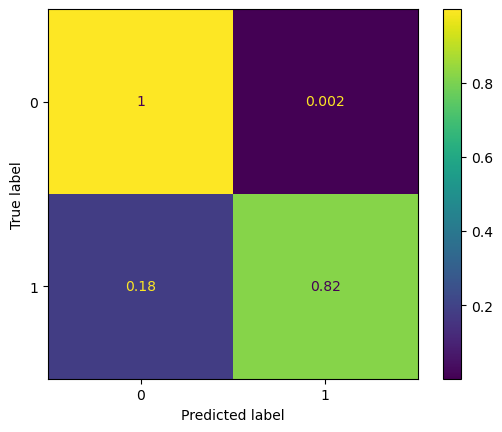

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_preds, normalize = 'true')

## 10.  Features Importance

**[10.1]** Task: Print the features importance of rf_best

In [40]:
rf_best.feature_importances_

array([8.81583915e-02, 5.39621646e-02, 6.05461168e-02, 4.22700495e-02,
       3.63268699e-02, 5.55616576e-02, 1.50937602e-01, 2.04231921e-01,
       1.06092618e-01, 5.40835776e-02, 9.78328714e-02, 2.69864320e-03,
       3.65376247e-03, 1.94017589e-04, 3.58705659e-03, 3.36511980e-03,
       2.63322121e-03, 2.63385739e-03, 3.75683552e-04, 1.05027715e-03,
       6.37819573e-03, 6.67758295e-03, 2.87825084e-03, 4.12447227e-03,
       1.40446799e-03, 2.76296777e-03, 3.66652509e-03, 6.49834269e-04,
       1.26222299e-03])

**[10.2]** Create a Dataframe with these values

In [41]:
feat_imp_rf_df = pd.DataFrame(
    {
        'feature': X_data.columns,
     'feature_importance': rf_best.feature_importances_
     }
)

In [42]:
feat_imp_rf_df

,feature,feature_importance
0,age_of_vehicle_years,0.088158
1,sched_serv_warr,0.053962
2,non_sched_serv_warr,0.060546
3,sched_serv_paid,0.042270
4,non_sched_serv_paid,0.036327
5,total_paid_services,0.055562
6,total_services,0.150938
7,mth_since_last_serv,0.204232
8,annualised_mileage,0.106093
9,num_dealers_visited,0.054084


**[10.3]** Sort the previous dataframe and reset its index

In [43]:
feat_imp_rf_df = feat_imp_rf_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)

**[10.4]** Display the first 10 rows of this dataframe 

In [44]:
feat_imp_rf_df.head(10)

,feature,feature_importance
0,mth_since_last_serv,0.204232
1,total_services,0.150938
2,annualised_mileage,0.106093
3,num_serv_dealer_purchased,0.097833
4,age_of_vehicle_years,0.088158
5,non_sched_serv_warr,0.060546
6,total_paid_services,0.055562
7,num_dealers_visited,0.054084
8,sched_serv_warr,0.053962
9,sched_serv_paid,0.042270


**[10.5]** We can visualise this information on a graph

In [45]:
alt.Chart(feat_imp_rf_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance'])

alt.Chart(...)